<a href="https://colab.research.google.com/github/ganeshred/NLPAuthorshipAttributionNLM/blob/main/bi_LSTM_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/balanced_task2.csv')

In [ ]:
len(df)

2136

In [ ]:
df.head()

,Unnamed: 0,text,class
0,664,Netanyahu barely scratches out a victory in Is...,0
1,61,"In ""Hunters,"" the premiere episode of a new se...",0
2,518,. cricket ice cream is a luxury ice cream made...,0
3,248,Graciela Iturbide was born in Mexico City in 1...,0
4,435,A new study from the University of Rochester d...,0


In [ ]:
df[['Generation']] = df[['text']]. astype(str)

In [ ]:
df = df[['Generation','class']]

In [ ]:
# text_field = data.Field(
#     sequential=True,
#     tokenize='basic_english', 
#     fix_length=500,
#     lower=True
# )
TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(sequential=False, use_vocab=False, dtype = torch.float)

# label_field = data.Field(sequential=False, use_vocab=False)

# sadly have to apply preprocess manually
preprocessed_text = df['Generation'].apply(
    lambda x: TEXT.preprocess(x)
)

# load fastext simple embedding with 300d
TEXT.build_vocab(
    preprocessed_text, 
    max_size = 30000,
    vectors='glove.6B.50d',
    unk_init = torch.Tensor.normal_
)

# get the vocab instance
vocab = TEXT.vocab

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 33923.84it/s]


In [ ]:
ltoi = {l: i for i, l in enumerate(df['class'].unique())}

In [ ]:
df['label1'] = df['class'].apply(lambda y: ltoi[y])

class DataFrameDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                data.Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [ ]:
df1=df[['Generation','label1']]

In [ ]:
examples=[]
for i,row in df1.iterrows():
  # print(example)
  examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))

In [ ]:
# examples[2000].label
c=0
for i in examples:
  if type(i.label) != int:
    c+=1

In [ ]:
c

0

In [ ]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [ ]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.65, 0.15, 0.2], stratified=True, strata_field='label')

In [ ]:
len(train_dataset)

1389

In [ ]:
ltoi

{0: 0, 1: 1}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
# device = 'cpu'
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=32,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cuda


In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        #1. Initialize Embedding Layer
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim, padding_idx = pad_idx)
        #2. Initialize LSTM layer
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, dropout = dropout, bidirectional = bidirectional)
        #3. Initialize a fully connected layer with Linear transformation
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        #4. Initialize Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        #1. Apply embedding layer that matches each word to its vector and apply dropout. Dim [sent_len, batch_size, emb_dim]
        embedding = self.embedding(text)
        embedding_dropout = self.dropout(embedding)
        #2. Run the LSTM along the sentences of length sent_len. #output = [sent len, batch size, hid dim * num directions]; #hidden = [num layers * num directions, batch size, hid dim]
        output, (hidden,cell) = self.lstm(embedding_dropout)
        #3. Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and apply dropout
        concat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(concat)     
        return self.fc(hidden)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 126
OUTPUT_DIM = 11
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT,
            PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,065,347 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([30002, 50])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  0.7372,  0.3910,  0.5158],
        [ 0.1825, -0.0737,  0.3147,  ...,  1.3226, -2.6796, -0.1297],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        ...,
        [-0.0786,  1.5932, -0.6019,  ..., -2.0051, -0.7769, -0.5551],
        [-0.1020, -0.0747, -1.2522,  ..., -0.4305,  0.2201, -0.3715],
        [ 0.0684,  2.0036, -0.2504,  ...,  1.1077,  2.4547,  0.1748]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0134,  0.2368, -0.1690,  ..., -0.5666,  0.0447,  0.3039],
        ...,
        [-0.0786,  1.5932, -0.6019,  ..., -2.0051, -0.7769, -0.5551],
        [-0.1020, -0.0747, -1.2522,  ..., -0.4305,  0.2201, -0.3715],
        [ 0.0684,  2.0036, -0.2504,  ...,  1.1077,  2.4547,  0.1748]])


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

# device='cpu'
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def multiclass_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # get the index of the highest prediction for each instance
    _, preds = torch.max(preds, dim=1)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        # print(batch.text)
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)

        target = batch.label
        target = target.type(torch.LongTensor)

        # print(target)

        # print(predictions)
        
        loss = criterion(predictions.to(device), target.to(device))
        
        acc = multiclass_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            target = batch.label
            target = target.type(torch.LongTensor)
            
            loss = criterion(predictions.to(device), target.to(device))
            
            acc = multiclass_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()



    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_losses_list = []
valid_losses_list = []
train_accs=[]
valid_accs=[]

In [ ]:




N_EPOCHS = 25
path = F"/content/gdrive/My Drive/bilstm_model_task2.pt"
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_losses_list.append(train_loss)
    valid_losses_list.append(valid_loss)
    train_accs.append(train_acc*100)
    valid_accs.append(valid_acc*100)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.139 | Train Acc: 45.27%
	 Val. Loss: 0.682 |  Val. Acc: 55.94%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.660 | Train Acc: 64.74%
	 Val. Loss: 0.744 |  Val. Acc: 58.44%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.578 | Train Acc: 71.77%
	 Val. Loss: 0.622 |  Val. Acc: 66.56%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.544 | Train Acc: 73.22%
	 Val. Loss: 0.600 |  Val. Acc: 69.69%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.487 | Train Acc: 76.74%
	 Val. Loss: 0.524 |  Val. Acc: 78.12%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.458 | Train Acc: 79.05%
	 Val. Loss: 0.580 |  Val. Acc: 77.50%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.460 | Train Acc: 79.45%
	 Val. Loss: 0.586 |  Val. Acc: 76.25%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.463 | Train Acc: 78.16%
	 Val. Loss: 0.522 |  Val. Acc: 75.94%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.477 | Train Acc: 78.98%
	 Val. Loss: 0.545 |  Val. Acc: 70.31%
Epoch: 10 | Epoch Time: 0m 3

In [ ]:
test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.401 | Test Acc: 87.30%


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

model.load_state_dict(torch.load(path))
model=model.to(device)

for batch in test_iter:
    text, labels = batch
    text,text_length=text
    text_length = text_length.to('cpu')
    predictions = model(text,text_length).squeeze(1)
    y_true.extend(labels.tolist())
    y_pred.extend(predictions.argmax(dim=1).tolist())  # convert to list of labels

# calculate the evaluation metrics using sklearn's functions
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.8782201405152225
Precision: 0.8785353535353535
Recall: 0.8781865648720987
F1 score: 0.8781874039938556


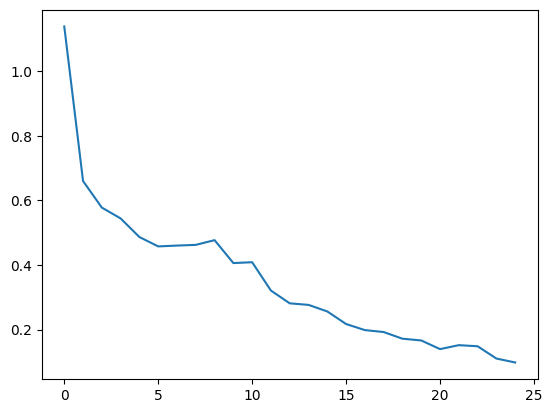

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses_list)

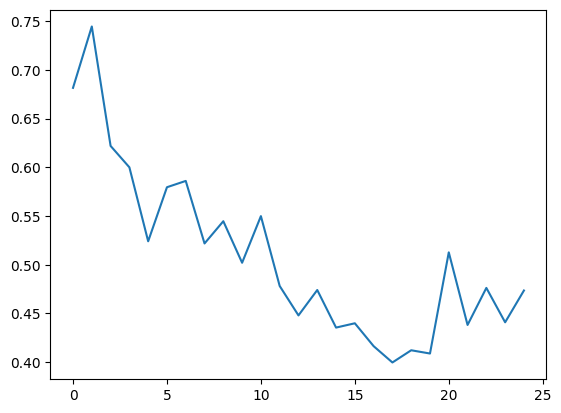

In [ ]:
plt.plot(valid_losses_list)

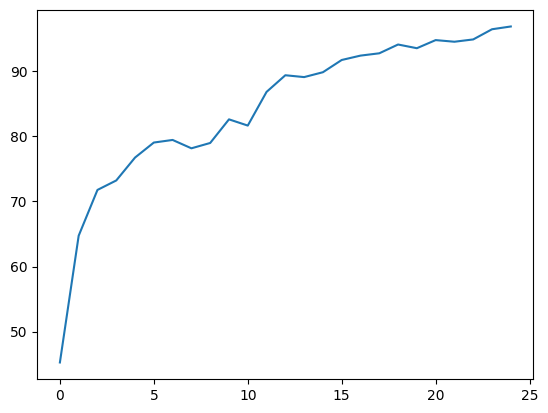

In [ ]:
plt.plot(train_accs)

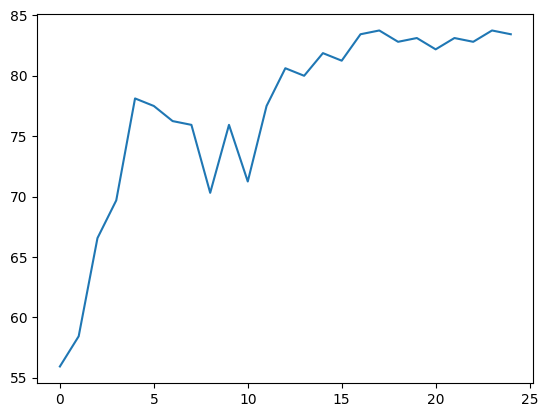

In [ ]:
plt.plot(valid_accs)

In [ ]:
def dataframetodataset(df):
  examples=[]
  for i,row in df.iterrows():
    # print(example)
    examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))
    dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])
    # train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print("We are working with ", device)
    # train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    #     datasets=(train_dataset, test_dataset, valid_dataset), 
    #     batch_size=16,
    #     sort_within_batch = True,
    #     sort_key=lambda x: len(x.text),
    #     device=device
    # )
  return dataset#,train_iter,test_iter,valid_iter







In [ ]:
reddit_df = pd.read_csv('/content/gdrive/MyDrive/NLP/reddit_data.csv')

In [ ]:
reddit_df = reddit_df[['Title']]

In [ ]:
reddit_df['label']=0

In [ ]:
dataset = dataframetodataset(reddit_df)

In [ ]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=16,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cuda


In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 126
OUTPUT_DIM = 11
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT,
            PAD_IDX)

In [ ]:
# model = torch.load(path)
model.load_state_dict(torch.load(path))


# Set the model to evaluation mode
# model.eval()
model = model.to(device)

In [ ]:
evaluate(model, test_iter, criterion)

(0.9464928482969602, 0.6343750009934107)

In [ ]:
evaluate(model, valid_iter, criterion)

(0.8141595497727394, 0.65625)

In [ ]:
evaluate(model, train_iter, criterion)

(0.9374440153439839, 0.5958333333333333)